# 0. Importando as Bibliotecas

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Importando o Numpy
import numpy as np

# Importando o Standard Scaler
from sklearn.preprocessing import StandardScaler

# Importando a classe KFold e StratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold

# Importando a classe LogisticRegression
from sklearn.linear_model import LogisticRegression

# Importando as funções para calcular o precision e o recall
from sklearn.metrics import precision_score, recall_score, average_precision_score, accuracy_score, f1_score

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

# 1. Funções que utilizaremos

In [1]:
def training_models(pipe, X_train, y_train, X_test, y_test, C_parameters:list=None):
    # valor defaul a serem testado para o hiperparâmetro C
    if not (C_parameters):
        C_parameters = [0.01, 0.1, 1, 10, 100]

    # Iniciando a lista que irá armazenar o desempenho do modelo para cada C
    list_accuracy = list()
    list_recall = list()
    list_precision = list()
    list_f1 = list()
    list_aucpr = list()

    print('Training.......')
    for n_iter, C_value in enumerate(C_parameters):
        print(f'+ {1+n_iter}/{len(C_parameters)}: C = {C_value:5} ... {(1+n_iter)/len(C_parameters):8.2%}')

        # Configurando o hiperparâmetro C
        pipe.set_params(classifier__C=C_value)

        # Treinando o modelo
        pipe.fit(X_train, y_train)

        # Previsões
        y_scores = pipe.decision_function(X_test)
        y_pred = pipe.predict(X_test)

        # Computando as métricas do modelo
        accuracy_Ci = accuracy_score(y_test, y_pred)
        recall_Ci = recall_score(y_test, y_pred)
        precision_Ci = precision_score(y_test, y_pred)
        f1_Ci = f1_score(y_test, y_pred)
        aucpr_Ci = average_precision_score(y_test, y_scores)

        # Salvando as métricas
        list_accuracy.append(accuracy_Ci)
        list_recall.append(recall_Ci)
        list_precision.append(precision_Ci)
        list_f1.append(f1_Ci)
        list_aucpr.append(aucpr_Ci)

    metrics_dict = {'accuracy':list_accuracy,
                  'recall':list_recall,
                  'precision':list_precision,
                  'f1':list_f1,
                  'aucpr':list_aucpr}

    return pd.DataFrame(metrics_dict, index=C_parameters)

# 2. Importando o conjunto de Dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
transactions = pd.read_csv('/content/drive/MyDrive/datasets/creditcard.csv')

In [7]:
transactions.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
transactions.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


## Dividindo o conjunto em Treino e Teste

In [10]:
X = transactions.drop(['Class', 'Time'], axis=1)
y = transactions['Class']

In [11]:
# Dividindo o conjunto em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=27)

In [12]:
# #Validation dataset
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=27)

In [13]:
# Copiando os datasets originais
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [14]:
# Formato dos dados de treino e teste
print('Treino:    ', X_train.shape, y_train.shape)
# print('Validação: ', X_val.shape, y_val.shape)
print('Teste:     ', X_test.shape, y_test.shape)

Treino:     (227845, 29) (227845,)
Teste:      (56962, 29) (56962,)


In [15]:
# Proporção do Target em cada conjunto
prop = pd.DataFrame({
    "Treino":y_train.value_counts(1),
    # "Validação":y_val.value_counts(1),
    "Teste":y_test.value_counts(1)
    })

prop

,Treino,Teste
Class,,
0,0.998271,0.99828
1,0.001729,0.00172


# 3. Modelagem

## 3.1 Feature Selection

In [ ]:
sf = SelectKBest(score_func=f_classif, k=10)
sf.fit(X_train, y_train)

SelectKBest()

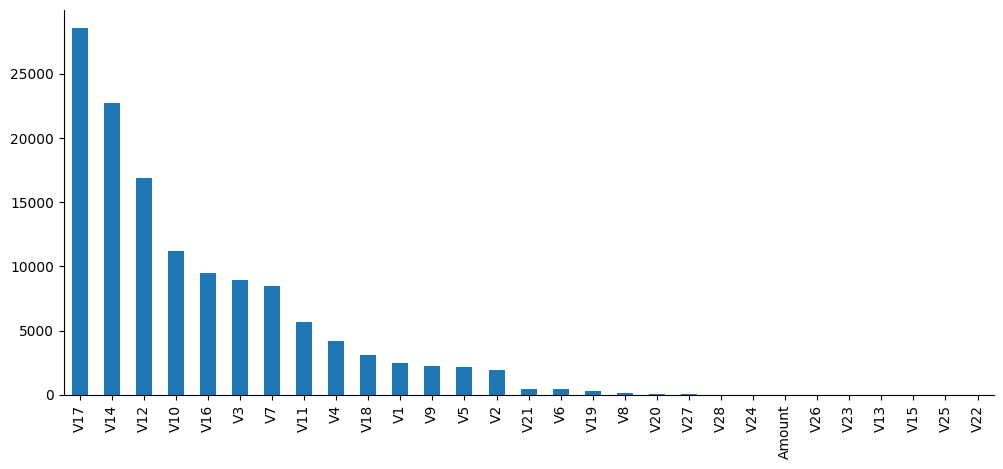

In [ ]:
scores = pd.Series(sf.scores_, index=sf.feature_names_in_, name='Score')
scores.sort_values(ascending=0).plot(kind='bar', figsize=(12,5))
sns.despine()
plt.show()

## 3.2 Fit models

### Linear

In [ ]:
clf_pipe_linear = Pipeline([
  ('scaler', StandardScaler()),
  ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
  ('classifier', LinearSVC(class_weight='balanced', dual=True, loss='hinge', verbose=0, random_state=27))
])

In [ ]:
df_metrics_linear = training_models(clf_pipe_linear, X_train, y_train, X_test, y_test)

Training.......
+ 1/5: C =  0.01 ...   20.00%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


+ 2/5: C =   0.1 ...   40.00%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


+ 3/5: C =     1 ...   60.00%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


+ 4/5: C =    10 ...   80.00%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


+ 5/5: C =   100 ...  100.00%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
df_metrics_linear.head()

,accuracy,recall,precision,f1,aucpr
0.01,0.981426,0.928571,0.079685,0.146774,0.779732
0.10,0.980074,0.938776,0.075348,0.139500,0.779744
1.00,0.999403,0.785714,0.855556,0.819149,0.787582
10.00,0.999421,0.785714,0.865169,0.823529,0.737544
100.00,0.999421,0.775510,0.873563,0.821622,0.724712


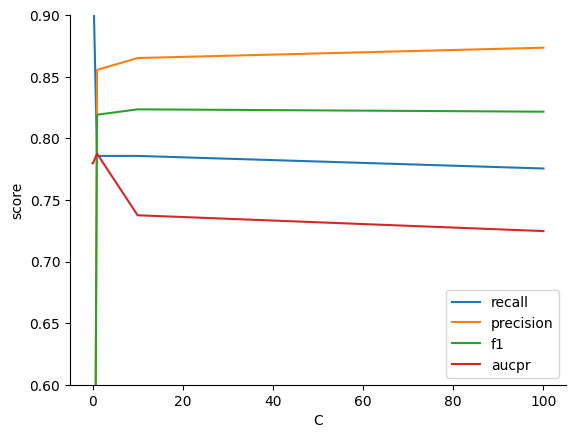

In [ ]:
#  Altera o valor de C significa um tradeoff entre Precision e Recall, ou seja, um aumente e o outro cai.
df_metrics_linear[['recall', 'precision', 'f1', 'aucpr']].plot()
plt.ylabel('score')
plt.xlabel('C')
plt.ylim([0.6, 0.9])
sns.despine()
plt.show()

###  Poly

In [ ]:
model_poly = SVC(kernel='poly',
                 degree=2,
                 class_weight=None,
                 max_iter=-1,
                 random_state=27
                 )

clf_pipe_poly = Pipeline([
  ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
  ('classifier', model_poly)
])

In [ ]:
df_metrics_poly = training_models(clf_pipe_poly, X_train, y_train, X_test, y_test, C_parameters=[0.01, 0.1, 1, 10])

Training.......
+ 1/4: C =  0.01 ...   25.00%
+ 2/4: C =   0.1 ...   50.00%
+ 3/4: C =     1 ...   75.00%
+ 4/4: C =    10 ...  100.00%


In [ ]:
df_metrics_poly.head()

,accuracy,recall,precision,f1,aucpr
0.01,0.999315,0.653061,0.927536,0.766467,0.769096
0.10,0.999350,0.653061,0.955224,0.775758,0.746532
1.00,0.999333,0.642857,0.954545,0.768293,0.729440
10.00,0.999333,0.642857,0.954545,0.768293,0.728739


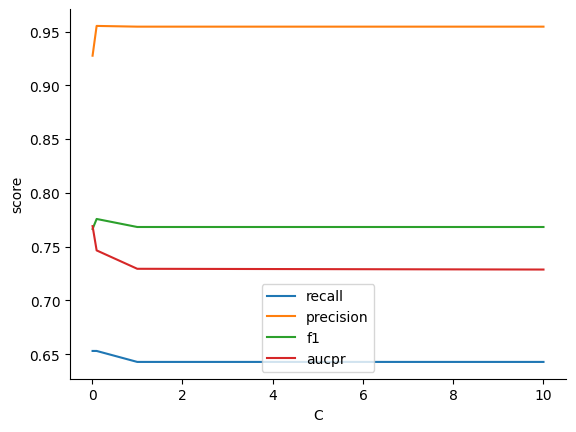

In [ ]:
#  Altera o valor de C significa um tradeoff entre Precision e Recall, ou seja, um aumente e o outro cai.
df_metrics_poly[['recall', 'precision', 'f1', 'aucpr']].plot()
plt.ylabel('score')
plt.xlabel('C')
sns.despine()
plt.show()

###  rbf

In [ ]:
model_rbf = SVC(kernel='rbf',
                 class_weight=None,
                 random_state=42
                 )

clf_pipe_rbf = Pipeline([
  ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
  ('classifier', model_rbf)
])

In [ ]:
df_metrics_rbf = training_models(clf_pipe_rbf, X_train, y_train, X_test, y_test)

Training.......
+ 1/5: C =  0.01 ...   20.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+ 2/5: C =   0.1 ...   40.00%
+ 3/5: C =     1 ...   60.00%
+ 4/5: C =    10 ...   80.00%
+ 5/5: C =   100 ...  100.00%


In [ ]:
df_metrics_rbf.head()

,accuracy,recall,precision,f1,aucpr
0.01,0.998280,0.000000,0.000000,0.000000,0.819833
0.10,0.998613,0.193878,1.000000,0.324786,0.821179
1.00,0.999526,0.744898,0.973333,0.843931,0.844724
10.00,0.999649,0.826531,0.964286,0.890110,0.832517
100.00,0.999544,0.785714,0.939024,0.855556,0.829196


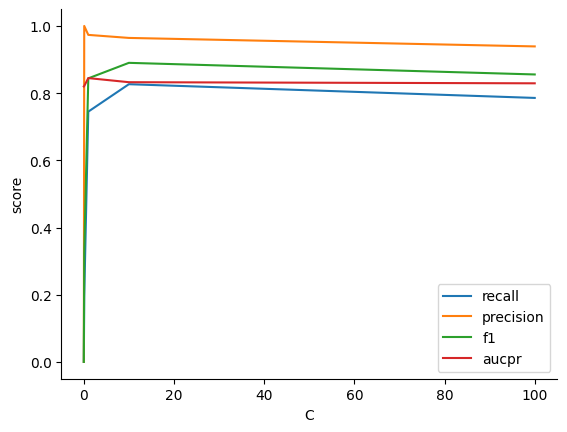

In [ ]:
# Segue a mesma lógica. A recall tente a aumentar e a precision tender a cair.
# Veja que para esse núcleo, o aucpr é maior que os demais. Indicando que haveria outros pontos de cortes.
df_metrics_rbf[['recall', 'precision', 'f1', 'aucpr']].plot()
plt.ylabel('score')
plt.xlabel('C')
sns.despine()
plt.show()

### sigmoid

In [16]:
model_sig = SVC(kernel='sigmoid',
                 class_weight=None,
                random_state=42
                 )

clf_pipe_sig = Pipeline([
  ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
  ('classifier', model_sig)
])

In [17]:
df_metrics_sig = training_models(clf_pipe_sig, X_train, y_train, X_test, y_test)

Training.......
+ 1/5: C =  0.01 ...   20.00%
+ 2/5: C =   0.1 ...   40.00%
+ 3/5: C =     1 ...   60.00%
+ 4/5: C =    10 ...   80.00%
+ 5/5: C =   100 ...  100.00%


In [18]:
df_metrics_sig.head()

,accuracy,recall,precision,f1,aucpr
0.01,0.998122,0.0,0.0,0.0,0.003002
0.10,0.996787,0.0,0.0,0.0,0.002984
1.00,0.996419,0.0,0.0,0.0,0.002976
10.00,0.996384,0.0,0.0,0.0,0.002974
100.00,0.996384,0.0,0.0,0.0,0.002974


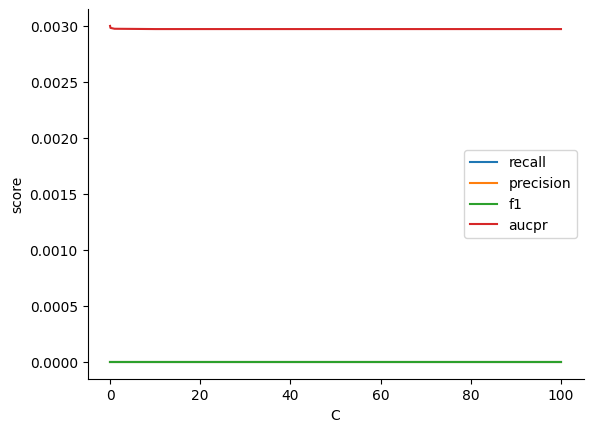

In [19]:
#  Altera o valor de C significa um tradeoff entre Precision e Recall, ou seja, um aumente e o outro cai.
df_metrics_sig[['recall', 'precision', 'f1', 'aucpr']].plot()
plt.ylabel('score')
plt.xlabel('C')
sns.despine()
plt.show()

# 4. Conclusão

* Aparentemente, o modelo SVC com kernel="rbf" obteve melhor desempenho que os demais kernels.